In [1]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive
df=pd.read_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_machine_learning.csv')
df['gravité_accident'] = df['gravité_accident'].replace({2: 'sans_urgence', 3: 'urgence', 4: 'sans_urgence'})
df['gravité_accident'].value_counts()

Mounted at /content/drive


,count
gravité_accident,
sans_urgence,190997
urgence,82229


In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as imPipeline  # Utilisation d'un pipeline d'imblearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

XGBOOST avec l'argument classweight pour gérer le déséquilibre des classes: cela permet de ne pas rajouter de données (contrairement à l'oversampling qui va rajouter des données de la classe minoritaire), sur un dataset qui est déjà très lourd.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:54:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy du modèle : 0.70

Rapport de classification :
              precision    recall  f1-score   support

           0       0.84      0.70      0.77     38200
           1       0.50      0.70      0.59     16446

    accuracy                           0.70     54646
   macro avg       0.67      0.70      0.68     54646
weighted avg       0.74      0.70      0.71     54646



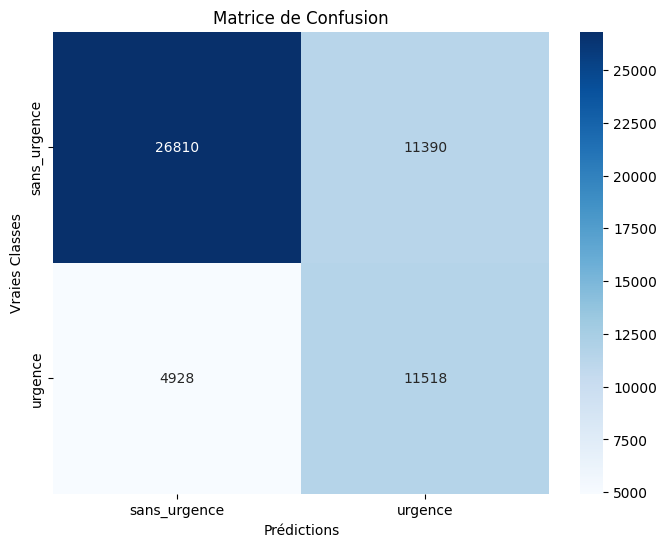

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparation des variables d'entrée et de sortie
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger',
             'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Encoder les classes texte en entiers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Transforme 'sans_urgence' et 'urgence' en 0 et 1

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Variables à encoder
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre',
                        'usager_count', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant',
                        'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre',
                        'place_conducteur', 'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme',
                        '0-17', '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV',
                        'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car',
                        'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Transformation des données
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features),
    ('scaler', StandardScaler(), passthrough_features)  # Normalisation pour XGBoost
])

# Calcul des poids des classes
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Créer et entraîner le modèle XGBoost
model = XGBClassifier(
    objective='multi:softmax',  # Classification multiclasses
    num_class=3,  # Nombre de classes
    eval_metric='mlogloss',  # Log loss
    use_label_encoder=False,  # Suppression d'un avertissement lié à XGBoost
    random_state=42
)

# Appliquer la transformation de prétraitement sur les données d'entraînement
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Entraîner le modèle avec les poids de classes
model.fit(X_train_transformed, y_train, sample_weight=class_weights)

# Prédictions
y_pred = model.predict(X_test_transformed)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)  # Les labels sont déjà sous forme numérique
print(f"Accuracy du modèle : {accuracy:.2f}")

# Rapport de classification détaillé
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Visualisation de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies Classes')
plt.title('Matrice de Confusion')
plt.show()




XGBOOST avec oversampling

Accuracy du modèle avec oversampling : 0.74
Accuracy du modèle : 0.74
Précision : 0.73
Rappel : 0.74
F1-score : 0.73

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     38246
           1       0.58      0.47      0.52     16400

    accuracy                           0.74     54646
   macro avg       0.68      0.66      0.67     54646
weighted avg       0.73      0.74      0.73     54646



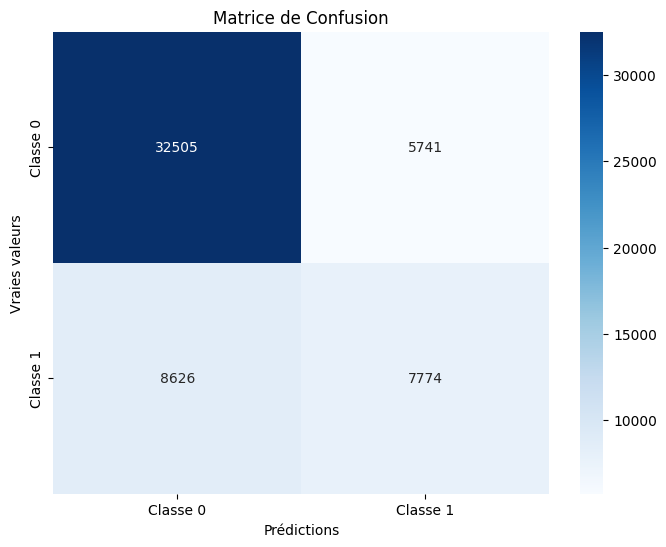

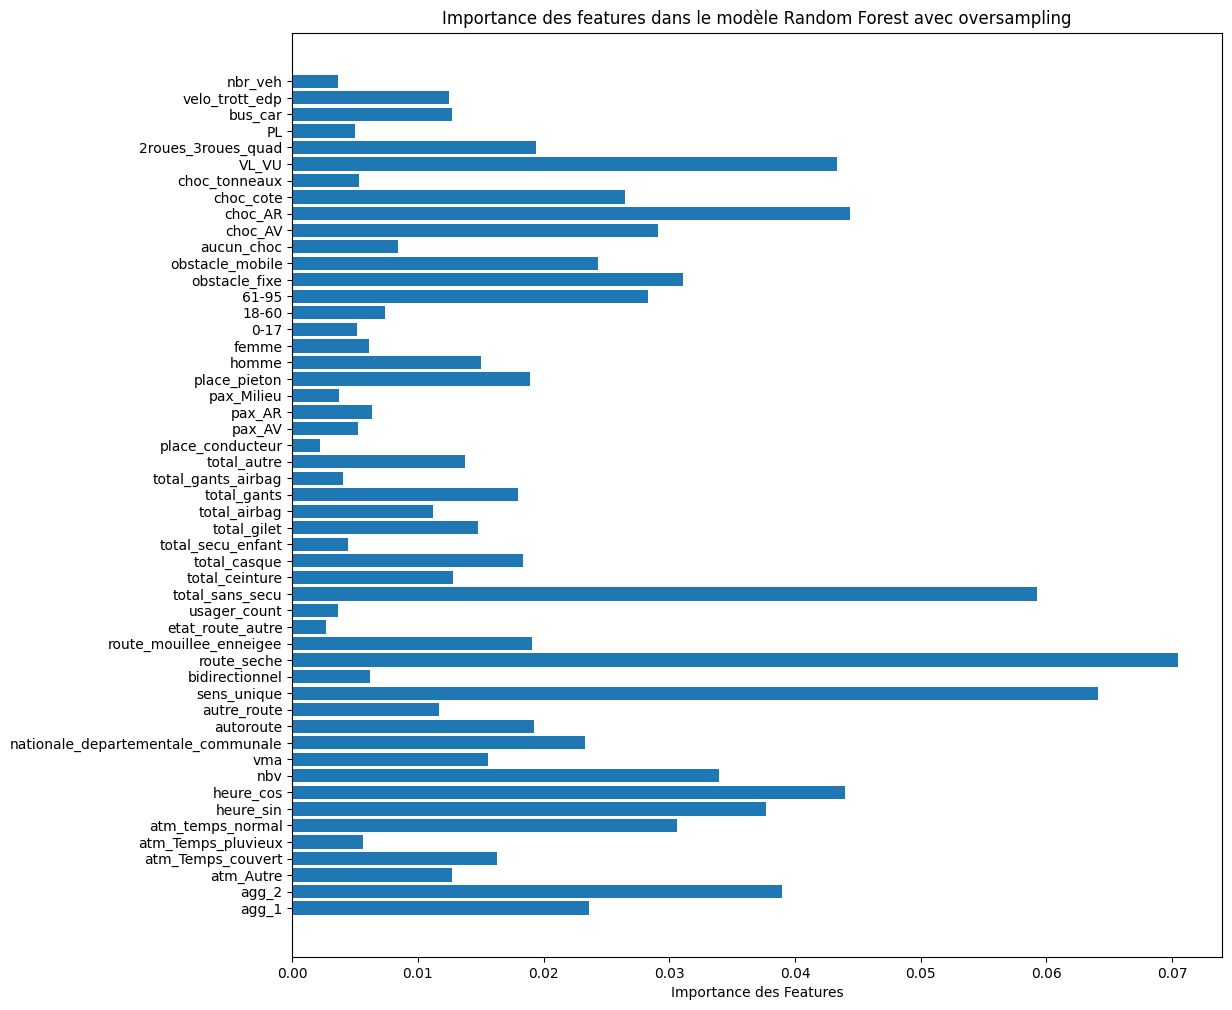

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

from sklearn.preprocessing import LabelEncoder

# Encoder les labels en entiers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['gravité_accident'])  # Convertit 'sans_urgence' -> 0 et 'urgence' -> 1

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Appliquer SMOTE dans la pipeline (avant l'entraînement du modèle)
smote = SMOTE(random_state=42, sampling_strategy = 'auto', k_neighbors = 5)

# Définir la pipeline complète avec SMOTE
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('smote', smote),  # Oversampling via SMOTE
    ('classifier', XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42))  # XGBoost
])

# Entraîner le modèle avec oversampling
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec oversampling : {accuracy:.2f}")

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")



# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec oversampling")
plt.show()
